# Beating State of the art EfficientNet B4 results on Food101

The goal of this experiment is to beat the 91.22% accuracy achieved in [this blog](https://whythinkaloud.com/2020/06/04/beating-efficientnet-b4-state-of-art-result-for-food101-dataset-using-fast-ai/).

We will be using the same model(EfficientNetB4) for transfer learning and finetuning the results.

We will be however using the noisy labelled training dataset to demonstrate robustness

## Getting the data

In [ ]:
import tensorflow_datasets as tfds

(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             as_supervised=True,
                                             with_info=True,
                                             shuffle_files=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteYT793N/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteYT793N/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


### Exploring the dataset

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
train_sample = train_data.take(1)
class_names = ds_info.features["label"].names

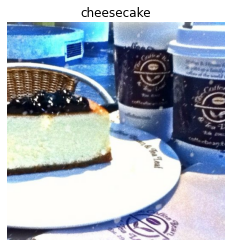

In [ ]:
for image, label in train_sample:
  plt.imshow(image)
  plt.title(class_names[label])
  plt.axis(False)

## Preprocessing and batchifying data

In [ ]:
import tensorflow as tf

def preprocess_img(image, label, image_shape=512):
  image = tf.image.resize(image, [image_shape, image_shape])
  return (tf.cast(image, tf.float32), label)

In [ ]:
train_data_preprocessed = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
train_data_ready = train_data_preprocessed.shuffle(buffer_size=1024).batch(batch_size=16).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data_ready = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=16).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building Augmentation Layers

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [ ]:
data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  layers.RandomZoom(0.2),
  layers.RandomContrast(0.2),
  layers.RandomCrop(400, 400),
  layers.RandomTranslation(0.3, 0.3),
  layers.GaussianNoise(2.0)
], name="data_augmentation")

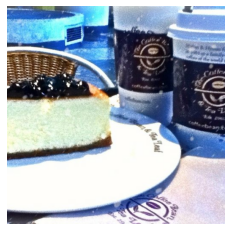

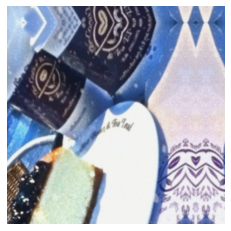

In [ ]:
plt.imshow(image)
plt.axis(False);

augmented_img = data_augmentation(tf.expand_dims(image, axis=0), training=True)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.axis(False);

## Building Base Model

In [ ]:
#Creating Callbacks

checkpoint_base = tf.keras.callbacks.ModelCheckpoint("models/checkpoints/base_model.h5",
                                                      save_best_only=True,
                                                      monitor="val_accuracy",
                                                      verbose=0)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=3)

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [ ]:
input_shape = (512, 512, 3)
base_model = tf.keras.applications.EfficientNetB4(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)


model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

71696384/71686520 [==============================] - 2s 0us/step


In [ ]:
history = model.fit(train_data_ready,
                    epochs=20,
                    steps_per_epoch=len(train_data_ready),
                    validation_data=test_data_ready,
                    validation_steps = int(0.1 * len(test_data_ready)),
                    callbacks = [tf.keras.callbacks.TensorBoard("tensorboard_logs/base_model"), checkpoint_base, early_stopping])

Epoch 1/20
4735/4735 [==============================] - 842s 172ms/step - loss: 2.0815 - accuracy: 0.4852 - val_loss: 1.2033 - val_accuracy: 0.6768
Epoch 2/20
4735/4735 [==============================] - 819s 172ms/step - loss: 1.7009 - accuracy: 0.5680 - val_loss: 1.1165 - val_accuracy: 0.6939
Epoch 3/20
4735/4735 [==============================] - 813s 171ms/step - loss: 1.6070 - accuracy: 0.5899 - val_loss: 1.0507 - val_accuracy: 0.7110
Epoch 4/20
4735/4735 [==============================] - 834s 175ms/step - loss: 1.5407 - accuracy: 0.6038 - val_loss: 1.0367 - val_accuracy: 0.7154
Epoch 5/20
4735/4735 [==============================] - 816s 172ms/step - loss: 1.5051 - accuracy: 0.6136 - val_loss: 1.0011 - val_accuracy: 0.7126
Epoch 6/20
4735/4735 [==============================] - 821s 173ms/step - loss: 1.4716 - accuracy: 0.6213 - val_loss: 0.9815 - val_accuracy: 0.7265
Epoch 7/20
4735/4735 [==============================] - 814s 171ms/step - loss: 1.4422 - accuracy: 0.6259 - val_

In [ ]:
model.evaluate(test_data_ready)

1579/1579 [==============================] - 213s 135ms/step - loss: 0.9198 - accuracy: 0.7434


[0.9197725653648376, 0.7434455156326294]

In [ ]:
base_model.trainable = True

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                metrics=["accuracy"])

In [ ]:
for i, layer in enumerate(model.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_1 True
1 rescaling True
2 normalization True
3 stem_conv_pad True
4 stem_conv True
5 stem_bn True
6 stem_activation True
7 block1a_dwconv True
8 block1a_bn True
9 block1a_activation True
10 block1a_se_squeeze True
11 block1a_se_reshape True
12 block1a_se_reduce True
13 block1a_se_expand True
14 block1a_se_excite True
15 block1a_project_conv True
16 block1a_project_bn True
17 block1b_dwconv True
18 block1b_bn True
19 block1b_activation True
20 block1b_se_squeeze True
21 block1b_se_reshape True
22 block1b_se_reduce True
23 block1b_se_expand True
24 block1b_se_excite True
25 block1b_project_conv True
26 block1b_project_bn True
27 block1b_drop True
28 block1b_add True
29 block2a_expand_conv True
30 block2a_expand_bn True
31 block2a_expand_activation True
32 block2a_dwconv_pad True
33 block2a_dwconv True
34 block2a_bn True
35 block2a_activation True
36 block2a_se_squeeze True
37 block2a_se_reshape True
38 block2a_se_reduce True
39 block2a_se_expand True
40 block2a_se_excite True
41 

In [ ]:
#Creating Callbacks

checkpoint_base = tf.keras.callbacks.ModelCheckpoint("models/checkpoints/model_open.h5",
                                                      save_best_only=True,
                                                      monitor="val_accuracy",
                                                      verbose=0)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=3)

In [ ]:
history_2 = model.fit(train_data_ready,
                        epochs=40,
                        steps_per_epoch=len(train_data_ready),
                        validation_data=test_data_ready,
                        validation_steps=(0.1 * len(test_data_ready)),
                        initial_epoch = history.epoch[-1],
                        callbacks=[checkpoint_base, early_stopping, tf.keras.callbacks.TensorBoard("tensorboard_logs/model_opened")])

Epoch 16/40
4735/4735 [==============================] - 3262s 682ms/step - loss: 1.7088 - accuracy: 0.5635 - val_loss: 1.0492 - val_accuracy: 0.7152
Epoch 17/40
4735/4735 [==============================] - 3224s 680ms/step - loss: 1.5299 - accuracy: 0.6190 - val_loss: 0.9479 - val_accuracy: 0.7326
Epoch 18/40
3662/4735 [======================>.......] - ETA: 12:04 - loss: nan - accuracy: 0.5775

KeyboardInterrupt: ignored

In [ ]:
model.evaluate(test_data_ready)

  89/1579 [>.............................] - ETA: 3:24 - loss: nan - accuracy: 0.0723

KeyboardInterrupt: ignored

In [ ]:
model_2 = tf.keras.models.load_model("models/checkpoints/model_open.h5")

In [ ]:
model_2.evaluate(test_data_ready)

1579/1579 [==============================] - 218s 135ms/step - loss: 0.9773 - accuracy: 0.7349


[0.97726970911026, 0.734930694103241]